In [1]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.utils import train_fn
from astra.torch.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
path = "/home/vannsh.jani/brick_kilns/ssl_exp/data"
x_train = torch.load(join(path, "ban_x_train.pt"))
y_train = torch.load(join(path, "ban_y_train.pt"))
x_test = torch.load(join(path, "ban_x_test.pt"))
y_test = torch.load(join(path, "ban_y_test.pt"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_b = torch.cat([x_train, x_test], dim=0).to(device)
y_b = torch.cat([y_train, y_test], dim=0).to(device)

print(x_b.shape, y_b.shape)

torch.Size([19124, 3, 224, 224]) torch.Size([19124]) torch.Size([6375, 3, 224, 224]) torch.Size([6375])
torch.Size([25499, 3, 224, 224]) torch.Size([25499])


In [3]:
x_d = torch.load(join(path, "delhi_test_images_50.pt")).to(device)
y_d = torch.load(join(path, "delhi_test_labels_50.pt")).to(device)
print(x_d.shape, y_d.shape)

torch.Size([5013, 3, 224, 224]) torch.Size([5013])


In [4]:
# Downstream model
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg_lc')
        print(self.model.linear_head)
        self.model.linear_head = nn.Linear(1920, num_classes)

    def forward(self, x):
        return self.model(x)

In [5]:
model = DownstreamModel(2).to(device)
model(torch.rand(2, 3, 224, 224).to(device)).shape

Using cache found in /home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/patel_zeel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Linear(in_features=1920, out_features=1000, bias=True)


torch.Size([2, 2])

In [6]:
lr = 1e-4
epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(epochs):
    print("Epoch:", epoch)
    model.train()
    iter_losses, epoch_losses = train_fn(model, loss_fn, x_b, y_b, lr=lr, epochs=1, batch_size=64)
    
    model.eval()
    
    with torch.no_grad():
        local_losses = []
        for i in range(0, len(x_b), 64):
            y_pred = model(x_b[i:i+64])
            loss = loss_fn(y_pred, y_b[i:i+64].long())
            local_losses.append(loss.item())

        train_losses.append(sum(local_losses)/len(local_losses))
    
    with torch.no_grad():
        y_pred = model(x_d)
        test_loss = loss_fn(y_pred, y_d.long())
        test_losses.append(test_loss.item())
        y_pred = torch.argmax(y_pred, dim=1)
        print("Accuracy:", accuracy_score(y_d, y_pred))
        print("Precision:", precision_score(y_d, y_pred))
        print("Recall:", recall_score(y_d, y_pred))
        print("F1 Score:", f1_score(y_d, y_pred))
        print("Train Loss:", train_losses[-1])
        print("Test Loss:", test_losses[-1])
        
    torch.cuda.empty_cache()

Epoch: 0


Loss: 0.18875323: 100%|██████████| 1/1 [01:22<00:00, 82.01s/it]


Accuracy: tensor(0.8699, device='cuda:0')
Precision: tensor(0.2649, device='cuda:0')
Recall: tensor(0.3391, device='cuda:0')
F1 Score: tensor(0.2974, device='cuda:0')
Train Loss: 0.1233512227864642
Test Loss: 0.3031131625175476
Epoch: 1


Loss: 0.10208143: 100%|██████████| 1/1 [01:21<00:00, 81.88s/it]


Accuracy: tensor(0.8997, device='cuda:0')
Precision: tensor(0.4031, device='cuda:0')
Recall: tensor(0.5224, device='cuda:0')
F1 Score: tensor(0.4550, device='cuda:0')
Train Loss: 0.0719366723480156
Test Loss: 0.24191375076770782
Epoch: 2


Loss: 0.07765182: 100%|██████████| 1/1 [01:21<00:00, 81.90s/it]


Accuracy: tensor(0.9003, device='cuda:0')
Precision: tensor(0.4319, device='cuda:0')
Recall: tensor(0.5245, device='cuda:0')
F1 Score: tensor(0.4737, device='cuda:0')
Train Loss: 0.06992881566771589
Test Loss: 0.23145219683647156
Epoch: 3


Loss: 0.06607926: 100%|██████████| 1/1 [01:21<00:00, 81.89s/it]


Accuracy: tensor(0.9037, device='cuda:0')
Precision: tensor(0.6353, device='cuda:0')
Recall: tensor(0.5304, device='cuda:0')
F1 Score: tensor(0.5782, device='cuda:0')
Train Loss: 0.055453838495757045
Test Loss: 0.23575833439826965
Epoch: 4


Loss: 0.05624641: 100%|██████████| 1/1 [01:21<00:00, 81.89s/it]


Accuracy: tensor(0.9033, device='cuda:0')
Precision: tensor(0.1612, device='cuda:0')
Recall: tensor(0.6364, device='cuda:0')
F1 Score: tensor(0.2573, device='cuda:0')
Train Loss: 0.07117814935725135
Test Loss: 0.2478010058403015
Epoch: 5


Loss: 0.04559744: 100%|██████████| 1/1 [01:21<00:00, 81.90s/it]


Accuracy: tensor(0.9005, device='cuda:0')
Precision: tensor(0.3474, device='cuda:0')
Recall: tensor(0.5324, device='cuda:0')
F1 Score: tensor(0.4204, device='cuda:0')
Train Loss: 0.05960180873826221
Test Loss: 0.27617835998535156
Epoch: 6


Loss: 0.04196246: 100%|██████████| 1/1 [01:21<00:00, 81.88s/it]


Accuracy: tensor(0.9042, device='cuda:0')
Precision: tensor(0.0998, device='cuda:0')
Recall: tensor(0.8254, device='cuda:0')
F1 Score: tensor(0.1781, device='cuda:0')
Train Loss: 0.04133147687679227
Test Loss: 0.2982013523578644
Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

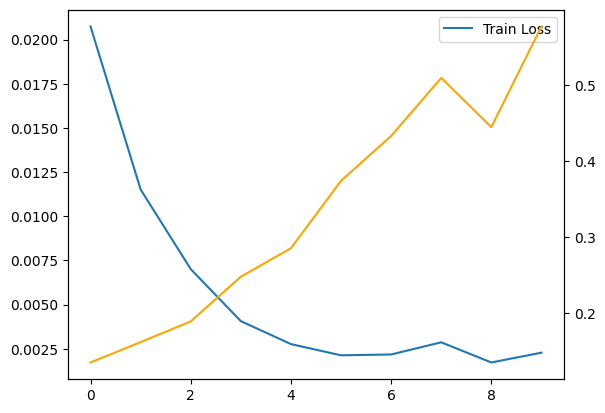

In [7]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.gca().twinx().plot(test_losses, label="Test Loss", color="orange")
# torch.save(model.state_dict(), "byol_lr4_ep50.pth")

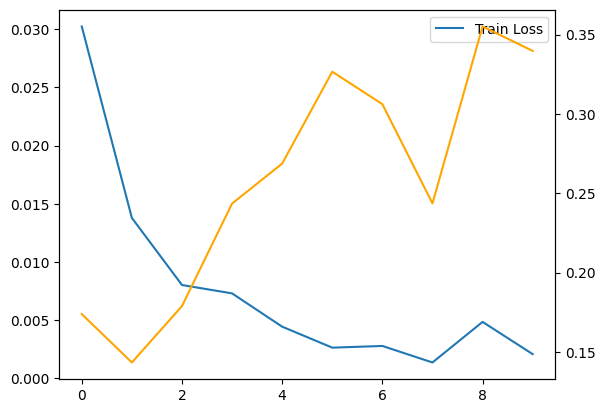